# Accessing Wikidata Content
This notebook provides a tutorial for how to access content in Wikidata either via the [JSON dumps](https://www.wikidata.org/wiki/Wikidata:Database_download#JSON_dumps_(recommended)) or [API](https://www.mediawiki.org/wiki/Wikibase/API). It has three stages:
* Accessing the Wikidata JSON dumps
* Accessing the Wikidata APIs
* Example analysis of Wikidata data (both descriptive statistics and learning a predictive model)

## Accessing the Wikidata JSON Dumps
This is an example of how to parse through [JSON dumps](https://www.wikidata.org/wiki/Wikidata:Database_download#JSON_dumps_(recommended)) and gather [statements](https://en.wikipedia.org/wiki/Wikidata#Statements) (property:value) for all items with at least one Wikipedia [sitelink](https://en.wikipedia.org/wiki/Wikipedia:Wikidata#Interlanguage_links_(Phase_1)). This can obviously be adjusted for whatever filtering etc. is desired. Of note, the JSON dumps are over 50 GB compressed and thus processing them can easily take a full day. If this is done via PAWS, the service will time-out.

In [1]:
import bz2
from copy import deepcopy
import json
import os
import time

In [2]:
# directory on PAWS server that holds Wikidata JSON dump
WIKIDATA_DIR = "/public/dumps/public/wikidatawiki/entities/"
WIKIDATA_DUMP_FN = 'latest-all.json.bz2'
# these next two variables just control progress statements and control how many items are processed
# there are tens of millions of Wikidata items and processing all of them takes far too long for this notebook
PRINT_EVERY = 5000
STOP_AT = 12000

In [3]:
# show types of Wikidata entity dumps that are available
!ls {WIKIDATA_DIR}

20200810  20200828  20200912	latest-all.json.bz2    latest-lexemes.nt.gz
20200813  20200830  20200914	latest-all.json.gz     latest-lexemes.ttl.bz2
20200816  20200831  20200916	latest-all.nt.bz2      latest-lexemes.ttl.gz
20200817  20200903  20200918	latest-all.nt.gz       latest-truthy.nt.bz2
20200820  20200905  20200921	latest-all.ttl.bz2     latest-truthy.nt.gz
20200823  20200907  20200923	latest-all.ttl.gz
20200824  20200910  dcatap.rdf	latest-lexemes.nt.bz2


In [4]:
# Wikidata JSON dump we'll start processing (56 GB in size, compressed) so far too large to process the whole thing right now
!ls -shH "{WIKIDATA_DIR}{WIKIDATA_DUMP_FN}"

56G /public/dumps/public/wikidatawiki/entities/latest-all.json.bz2


In [7]:
# Inspect the first 500 characters of the JSON dump to see what it looks like
# Ignore the bzcat broken pipe err
!bzcat "{WIKIDATA_DIR}{WIKIDATA_DUMP_FN}" | head -n2 | cut -c1-500

[

bzcat: I/O or other error, bailing out.  Possible reason follows.
bzcat: Broken pipe
	Input file = /public/dumps/public/wikidatawiki/entities/latest-all.json.bz2, output file = (stdout)
{"type":"item","id":"Q31","labels":{"el":{"language":"el","value":"\u0392\u03ad\u03bb\u03b3\u03b9\u03bf"},"ay":{"language":"ay","value":"Bilkiya"},"pnb":{"language":"pnb","value":"\u0628\u06cc\u0644\u062c\u06cc\u0645"},"na":{"language":"na","value":"Berdjiyum"},"mk":{"language":"mk","value":"\u0411\u0435\u043b\u0433\u0438\u0458\u0430"},"bn":{"language":"bn","value":"\u09ac\u09c7\u09b2\u099c\u09bf\u09af\u09bc\u09be\u09ae"},"bpy":{"language":"bpy","value":"\u09ac\u09c7\u09b2\u099c\u09bf\u09af\u09b


In [5]:
# Example that loops through all Wikidata items with Wikipedia sitelinks and extracts properties + values
start_time = time.time()
items_kept = 0
data = []
with bz2.open(os.path.join(WIKIDATA_DIR, WIKIDATA_DUMP_FN), 'rt') as fin:
    next(fin)  # remove initial '[' character
    for idx, line in enumerate(fin, start=1):
        # load line (Wikidata item) as JSON
        try:
            item_json = json.loads(line[:-2])  # trim trailing comma + newline character
        except Exception:
            try:
                item_json = json.loads(line)  # final item does not have a comma
            except Exception:
                print("Error:", idx, line)
                continue

        if idx % PRINT_EVERY == 0:
            elapsed_time_sec = time.time() - start_time
            print("{0} lines processed. {1:.2f} minutes elapsed. {2} ({3:.1f}%) items kept".format(
                idx, elapsed_time_sec / 60, items_kept, 100 * items_kept / idx))
            
        if idx == STOP_AT:
            print("Reached limit of {0} items".format(STOP_AT))
            break
        
        # this is the unique identifier for a given Wikidata item
        qid = item_json.get('id', None)
        if not qid:
            continue
        
        # check that at least one wikipedia language edition has an article about the item
        # this is an loose proxy for Wikipedia links in that some extra items might slip through the filter
        # commonswiki and specieswiki are the most common "<something>wiki"s but metawiki, testwiki, etc. also exist
        # a better solution would be first downloading a list of all wiki names and then checking against that
        sitelinks = [l[:-4] for l in item_json.get('sitelinks', []) if l.endswith('wiki') and l != 'commonswiki' and l != 'specieswiki']
        num_sitelinks = len(sitelinks)
        if num_sitelinks == 0:
            continue
        
        # English title for ease of debugging and example of getting article titles
        en_title = item_json.get('sitelinks', {}).get('enwiki', {}).get('title', None)
        claims = item_json.get('claims', {})
        items_kept += 1
        num_statements = len(claims)

        # example of processing statements to get individual properties + values
        # in this case, we're gathering the # of statements, whether the item is about a person, and # of sitelinks
        is_human = False
        for prop in claims:  # each property, such as P31 instance-of
            for statement in claims[prop]:  # each value under that property -- e.g., instance-of might have three different values
                if statement.get('type') == 'statement':
                    prop_id = statement.get('mainsnak', {}).get('property')
                    if statement.get('mainsnak', {}).get('datatype') == 'wikibase-item':
                        value = statement['mainsnak'].get('datavalue', {}).get('value', {}).get('id')
                        if prop_id == 'P31' and value == 'Q5':
                            is_human = True
        data.append((qid, en_title, num_statements, num_sitelinks, is_human))
                        
elapsed_time_sec = time.time() - start_time
print("{0} lines processed. {1:.2f} minutes elapsed. {2} ({3:.1f}%) items kept".format(
    idx, elapsed_time_sec / 60, items_kept, 100 * items_kept / idx))

5000 lines processed. 0.15 minutes elapsed. 4995 (99.9%) items kept
10000 lines processed. 0.28 minutes elapsed. 9991 (99.9%) items kept
Reached limit of 12000 items
12000 lines processed. 0.31 minutes elapsed. 11990 (99.9%) items kept


### Show an example of the data

In [6]:
# Complete example item -- there is a lot of additional info we don't need though
item_json 

{'type': 'item',
 'id': 'Q100328',
 'labels': {'de': {'language': 'de', 'value': 'Volker Michael Strocka'},
  'fr': {'language': 'fr', 'value': 'Volker Michael Strocka'},
  'nb': {'language': 'nb', 'value': 'Volker Michael Strocka'},
  'da': {'language': 'da', 'value': 'Volker Michael Strocka'},
  'nn': {'language': 'nn', 'value': 'Volker Michael Strocka'},
  'sv': {'language': 'sv', 'value': 'Volker Michael Strocka'},
  'en': {'language': 'en', 'value': 'Volker Michael Strocka'},
  'nl': {'language': 'nl', 'value': 'Volker Michael Strocka'},
  'es': {'language': 'es', 'value': 'Volker Michael Strocka'},
  'el': {'language': 'el', 'value': 'Φόλκερ Μίκαελ Στρόκα'},
  'sl': {'language': 'sl', 'value': 'Volker Michael Strocka'},
  'nds': {'language': 'nds', 'value': 'Volker Michael Strocka'},
  'pt': {'language': 'pt', 'value': 'Volker Michael Strocka'},
  'ast': {'language': 'ast', 'value': 'Volker Michael Strocka'},
  'ca': {'language': 'ca', 'value': 'Volker Michael Strocka'},
  'it': 

In [7]:
# Just the data that we're interested in:
condensed_item_json = deepcopy(item_json)
# remove unnecessary data
parts_to_remove = ['type', 'labels', 'descriptions', 'aliases', 'lastrevid']
for k in parts_to_remove:
    condensed_item_json.pop(k)
# simplify sitelinks
sitelinks = [s for s in condensed_item_json['sitelinks']]
for wiki in sitelinks:
    condensed_item_json['sitelinks'][wiki] = condensed_item_json['sitelinks'][wiki]['title']
condensed_item_json
# simplify claims
properties = [p for p in condensed_item_json['claims']]
for p in properties:
    for statement_idx in range(0, len(condensed_item_json['claims'][p])):
        value = condensed_item_json['claims'][p][statement_idx]['mainsnak']['datavalue']
        if 'id' in value:
            condensed_item_json['claims'][p][statement_idx] = value['id']
        else:
            condensed_item_json['claims'][p][statement_idx] = value
condensed_item_json

{'id': 'Q100328',
 'claims': {'P21': [{'value': {'entity-type': 'item',
     'numeric-id': 6581097,
     'id': 'Q6581097'},
    'type': 'wikibase-entityid'}],
  'P244': [{'value': 'n82018223', 'type': 'string'}],
  'P214': [{'value': '17272533', 'type': 'string'}],
  'P227': [{'value': '121272141', 'type': 'string'}],
  'P213': [{'value': '0000 0001 2099 3773', 'type': 'string'}],
  'P69': [{'value': {'entity-type': 'item',
     'numeric-id': 153987,
     'id': 'Q153987'},
    'type': 'wikibase-entityid'}],
  'P19': [{'value': {'entity-type': 'item', 'numeric-id': 1794, 'id': 'Q1794'},
    'type': 'wikibase-entityid'}],
  'P31': [{'value': {'entity-type': 'item', 'numeric-id': 5, 'id': 'Q5'},
    'type': 'wikibase-entityid'}],
  'P569': [{'value': {'time': '+1940-02-26T00:00:00Z',
     'timezone': 0,
     'before': 0,
     'after': 0,
     'precision': 11,
     'calendarmodel': 'http://www.wikidata.org/entity/Q1985727'},
    'type': 'time'}],
  'P27': [{'value': {'entity-type': 'item',

## Accessing the Wikidata APIs
The [Wikidata APIs](https://www.mediawiki.org/wiki/Wikibase/API) can be much faster for accessing data about Wikidata items if you know what items you are interested in and are interested in relatively few items (e.g., hundreds or low thousands). To demonstrate, we'll show how to use the [wbgetentities endpoint](https://www.wikidata.org/w/api.php?action=help&modules=wbgetentities), which allows you to get all the statements and sitelinks associated with a Wikidata item. We choose a random sample of 10 items from the JSON dump to compare.

NOTE: the APIs are up-to-date while the JSON dumps are always at least several days behind -- i.e. for specific snapshots in time -- so the data you get from the JSON dumps might be different from the APIs if users have made edits to the Wikidata items in the intervening days.

In [8]:
import random

import mwapi

In [9]:
# Gather ten random Wikidata IDs from the data gathered from the JSON dump to get data for from the API
ten_random_items = random.sample(data, 10)
ten_random_items

[('Q64885', 'Melkite Greek Catholic Church', 18, 31, False),
 ('Q73308', 'Christian Louis, Count of Waldeck', 23, 8, True),
 ('Q16360', 'Aeronomy', 13, 30, False),
 ('Q91560', None, 41, 4, True),
 ('Q95986', 'Carl Hintze', 23, 5, True),
 ('Q37840', 'Finnish Hound', 12, 17, False),
 ('Q659', 'North', 23, 147, False),
 ('Q24319', 'SX Phoenicis variable', 7, 12, False),
 ('Q42379', 'Crespiatica', 36, 41, False),
 ('Q79577', 'Scottsboro, Alabama', 34, 35, False)]

In [10]:
# mwapi documentation: https://pypi.org/project/mwapi/
# user_agent helps identify the request if there's an issue and is best practice
tutorial_label = 'Wikidata API tutorial (mwapi)'
# NOTE: it is best practice to include a contact email in user agents
# generally this is private information though so do not change it to yours
# if you are working in the PAWS environment or adding to a Github repo
# for Outreachy, you can leave this as my (isaac's) email or switch it to your Mediawiki username
# e.g., Isaac (WMF) for https://www.mediawiki.org/wiki/User:Isaac_(WMF)
contact_email = 'isaac@wikimedia.org'
session = mwapi.Session('https://wikidata.org', user_agent='{0} -- {1}'.format(tutorial_label, contact_email))

# API endpoint: https://www.wikidata.org/w/api.php?action=help&modules=wbgetentities
params = {'action':'wbgetentities',
         'ids':'|'.join([d[0] for d in ten_random_items]),
         'props':'sitelinks|claims'}

In [11]:
result = session.get(params)
if result.get('success'):
    print("Results for:", list(result.get('entities', {}).keys()))
else:
    print(result)

Results for: ['Q64885', 'Q73308', 'Q16360', 'Q91560', 'Q95986', 'Q37840', 'Q659', 'Q24319', 'Q42379', 'Q79577']


In [12]:
# While we expect most of the data to align, it's not unexpected if a few do not
# because the dumps are at least several days out of date and the API is current
# so any edits in the past few days could lead to data mismatches

# for Q659, added kabwiki article: https://www.wikidata.org/w/index.php?title=Q659&diff=1281373660&oldid=1279797337
for item in result['entities']:
    api_num_statements = len(result['entities'][item]['claims'])
    api_num_sitelinks = len([s for s in result['entities'][item]['sitelinks'] if s.endswith('wiki') and s not in ('commonswiki', 'specieswiki')])
    for d in ten_random_items:
        if d[0] == item:
            dump_num_statements = d[2]
            dump_num_sitelinks = d[3]
    if api_num_sitelinks != dump_num_sitelinks:
        print("Mismatch ({0}): {1} sitelinks in dump and {2} from API".format(item, dump_num_sitelinks, api_num_sitelinks))
    if api_num_statements != dump_num_statements:
        print("Mismatch ({0}): {1} statements in dump and {2} from API".format(item, dump_num_statements, api_num_statements))

Mismatch (Q659): 147 sitelinks in dump and 148 from API


## Example Analyses of Wikidata data
Here we show some examples of things we can do with the data that we gathered about Wikidata items. We'll work with the larger dataset we gathered from the JSON dumps. There are many research questions you might come up with about Wikidata items, but we're going to examine the following:

There is a lot of content on wikis and much more that could be added but relatively few editors. As a result, there are always going to be topics that have excellent coverage and others that have just more basic information. Ideally, the topics that are covered well are also the "important" ones. We are going to do a basic analysis to see how well this holds up in Wikidata. Specifically, we choose to look at the relationship between the number of statements that a given Wikidata item has (a rough proxy of quality / coverage) and the number of languages in which there is a corresponding Wikipedia article (a rough proxy for interest / importance of the topic).

In [13]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

from IPython.display import display

sns.set()

In [14]:
# Convert data into more usable form
df = pd.DataFrame(data, columns=['QID', 'enwiki', '# statements', '# sitelinks', 'Human?'])
df.set_index('QID', inplace=True)
df.head()

,enwiki,# statements,# sitelinks,Human?
QID,,,,
Q31,Belgium,212,270,False
Q8,Happiness,39,103,False
Q23,George Washington,183,182,True
Q24,Jack Bauer,35,26,False
Q42,Douglas Adams,210,82,True


### Descriptive statistics
Basic details on number of statements and number of sitelinks per item. Conclusions:
* Both sitelinks and statements are positively skewed -- i.e. most items have relatively few statements/sitelinks but a few items have many statements/sitelinks
* Whether an item is a human or not seems to matter: people have fewer sitelinks but more statements on average that items that are not about people

,count,mean,std,min,25%,50%,75%,max
Human?,,,,,,,,
False,7499.0,23.267636,18.186535,0.0,10.0,20.0,32.0,250.0
True,4491.0,37.352928,25.664052,4.0,22.0,31.0,44.0,264.0


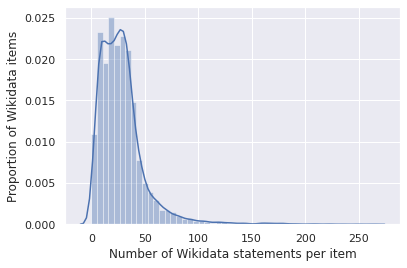

In [15]:
plt = sns.distplot(df['# statements'], axlabel = "Number of Wikidata statements per item")
_ = plt.set_ylabel('Proportion of Wikidata items')

df.groupby('Human?')['# statements'].describe()

,count,mean,std,min,25%,50%,75%,max
Human?,,,,,,,,
False,7499.0,38.380451,39.792828,1.0,10.0,28.0,45.0,293.0
True,4491.0,16.256958,21.791385,1.0,5.0,9.0,17.0,205.0


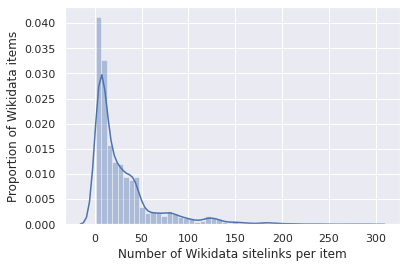

In [16]:
plt = sns.distplot(df['# sitelinks'], axlabel = "Number of Wikidata sitelinks per item")
_ = plt.set_ylabel('Proportion of Wikidata items')

df.groupby('Human?')['# sitelinks'].describe()

### Relationship between the two variables:
Relationship between # of sitelinks and # of statements. Conclusions:
* We see a clear positive correlation between # of sitelinks (our proxy for importance) and # of statements (our proxy for quality) -- i.e. Wikidata items with many statements also tend to show up in more languages of Wikipedia and high importance Wikidata items also tend to be high quality.
* The exact relationship depends, however, on whether the Wikidata item is about a person or not:
 * For people, there is a much stronger correlation (0.779 [Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient); 0.589 [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)) between # of sitelinks and # of statements than for other items (0.454 Pearson; 0.549 Spearman)
 * As a result of these differing relationships, grouping the data together actually makes the correlation look much weaker (Pearson 0.371; Spearman 0.381).

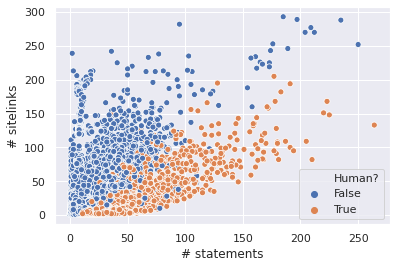

In [17]:
# Scatter plot of # statements x # sitelinks; humans vs. non-humans separated out
plt = sns.scatterplot(x='# statements', y='# sitelinks', hue='Human?', data=df)

In [18]:
# All items
print("Correlation (all items)")
pcorr_coef, pval = pearsonr(df['# statements'], df['# sitelinks'])
print("Pearson (linear) correlation between the # of statements and # of Wikipedia sitelinks: {0:.3f} (p={1:0.3f})".format(pcorr_coef, pval))

scorr_coef, pval = spearmanr(df['# statements'], df['# sitelinks'])
print("Spearman (rank) correlation between the # of statements and # of Wikipedia sitelinks: {0:.3f} (p={1:0.3f})".format(scorr_coef, pval))


Correlation (all items)
Pearson (linear) correlation between the # of statements and # of Wikipedia sitelinks: 0.370 (p=0.000)
Spearman (rank) correlation between the # of statements and # of Wikipedia sitelinks: 0.379 (p=0.000)


In [19]:
# Just humans
print("Correlation (just people)")
pcorr_coef, pval = pearsonr(df[df['Human?']]['# statements'], df[df['Human?']]['# sitelinks'])
print("Pearson (linear) correlation between the # of statements and # of Wikipedia sitelinks: {0:.3f} (p={1:0.3f})".format(pcorr_coef, pval))

scorr_coef, pval = spearmanr(df[df['Human?']]['# statements'], df[df['Human?']]['# sitelinks'])
print("Spearman (rank) correlation between the # of statements and # of Wikipedia sitelinks: {0:.3f} (p={1:0.3f})".format(scorr_coef, pval))


Correlation (just people)
Pearson (linear) correlation between the # of statements and # of Wikipedia sitelinks: 0.777 (p=0.000)
Spearman (rank) correlation between the # of statements and # of Wikipedia sitelinks: 0.584 (p=0.000)


In [20]:
# Not humans
print("Correlation (not people)")
pcorr_coef, pval = pearsonr(df[~df['Human?']]['# statements'], df[~df['Human?']]['# sitelinks'])
print("Pearson (linear) correlation between the # of statements and # of Wikipedia sitelinks: {0:.3f} (p={1:0.3f})".format(pcorr_coef, pval))

scorr_coef, pval = spearmanr(df[~df['Human?']]['# statements'], df[~df['Human?']]['# sitelinks'])
print("Spearman (rank) correlation between the # of statements and # of Wikipedia sitelinks: {0:.3f} (p={1:0.3f})".format(scorr_coef, pval))


Correlation (not people)
Pearson (linear) correlation between the # of statements and # of Wikipedia sitelinks: 0.456 (p=0.000)
Spearman (rank) correlation between the # of statements and # of Wikipedia sitelinks: 0.550 (p=0.000)


### Outlier analysis
We now visually examine the outliers -- i.e. articles with high quality but low importance or low quality but high importance. Conclusions:
* High quality, low importance: mostly people, generally not American (many Germans -- likely a function of our sample of Wikidata items)
* Low quality, high importance: not people -- years, categories, and other generic topics

In [21]:
# we split the data into deciles because the raw difference between # of sitelinks and # of statements
# tends to capture very high quality items that are still pretty high importance
# e.g., Edgar Allen Poe has 261 statements and 132 sitelinks
# which is a huge difference but still high quality and high importance
df['quality_decile'] = pd.qcut(df['# statements'], 10, labels=False)
df['importance_decile'] = pd.qcut(df['# sitelinks'], 10, labels=False)
df['qi_diff'] = df['quality_decile'] - df['importance_decile']
num_examples = 30

In [22]:
print("Top {0} highest-quality, lowest-importance articles:".format(num_examples))
display(df.sort_values('qi_diff', ascending=False)[['enwiki', '# statements', '# sitelinks', 'Human?']].head(n=num_examples))

Top 30 highest-quality, lowest-importance articles:


,enwiki,# statements,# sitelinks,Human?
QID,,,,
Q92112,Franz Skutsch,53,4,True
Q46568,Sweet Deceptions,52,4,False
Q32241,Incident at Loch Ness,53,4,False
Q98074,Sigmund Feyerabend,53,3,True
Q90090,Karl Schenkl,52,3,True
Q98310,Bernd Moeller,52,3,True
Q25942,Walther Klemm,58,3,True
Q98169,None,41,4,True
Q98164,None,47,2,True


In [23]:
print("Top {0} lowest-quality, highest-importance articles:".format(num_examples))
display(df.sort_values('qi_diff', ascending=True)[['enwiki', '# statements', '# sitelinks', 'Human?']].head(n=num_examples))

Top 30 lowest-quality, highest-importance articles:


,enwiki,# statements,# sitelinks,Human?
QID,,,,
Q4101,15 BC,8,92,False
Q31925,295,8,121,False
Q2238,January 9,8,195,False
Q35589,244 BC,6,78,False
Q31934,598,8,119,False
Q34551,373,8,120,False
Q25266,552,8,121,False
Q30577,894,8,127,False
Q75628,321 BC,7,79,False


### Predictive Model
We've established that there is a clear relationship between # of statements (quality) and # of sitelinks (importance) and that that relationship also depends on whether the item is about a person or not. Now we want to see with how much accuracy we can predict the number of sitelinks based on the number of statements about an item. This can tell us for which items we would expect articles in more languages to be written about them.

NOTE: the model presented below is very simplistic and so actually tells us very little that the correlational analyses didn't, but adding more variables and interactions between variables would allow for a more nuanced analysis of outliers.

In [24]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [25]:
# format data for modeling
X = df[['# statements', 'Human?']]
y = df[['# sitelinks']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print("X_train ({0}):\n{1}".format(len(X_train), X_train.head()))
print("\ny_train ({0}):\n{1}".format(len(y_train), y_train.head()))
print("\nX_test ({0}):\n{1}".format(len(X_test), X_test.head()))
print("\ny_test ({0}):\n{1}".format(len(y_test), y_test.head()))

X_train (10791):
        # statements  Human?
QID                         
Q39914            36   False
Q78425            42    True
Q82334            34   False
Q5454             62    True
Q74488            30    True

y_train (10791):
        # sitelinks
QID                
Q39914           40
Q78425            7
Q82334           19
Q5454            10
Q74488            6

X_test (1199):
        # statements  Human?
QID                         
Q70240            33   False
Q98265            30    True
Q14041            35   False
Q71288            17    True
Q18537            24   False

y_test (1199):
        # sitelinks
QID                
Q70240           25
Q98265            4
Q14041           62
Q71288           11
Q18537           66


In [26]:
# train model
# for ease, we pass X_train as a 2D numpy array and y_train as a vector
clf = LinearRegression().fit(X_train.values, y_train.values.ravel())

In [27]:
num_statement_coef, human_coef = clf.coef_
print("For every additional statement, we expect {0:.3f} additional sitelinks.".format(num_statement_coef))
print("If human, we expect {0:.3f} fewer sitelinks than an item with the same number of statements that's not about a human.".format(0 - human_coef))

For every additional statement, we expect 0.803 additional sitelinks.
If human, we expect 33.203 fewer sitelinks than an item with the same number of statements that's not about a human.


In [28]:
# Simple metric of model fit -- suggests an okay but not great model. Not surprising given how few features we have.
# No evidence of overfitting as this is similar to the R^2 on the train set which is 0.321: `clf.score(X_train, y_train)`
print("R^2 of model on held-out test set is: {0:.3f}".format(clf.score(X_test, y_test)))

R^2 of model on held-out test set is: 0.344


### Future Analyses
At this stage, we'd ideally add more data and variables. For example:
* Including more statements beyond just whether the items is about a human -- e.g., as a [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model)
* Considering switching from a simple linear regression to other model types
* Considering learning embeddings for the statements which could then be used to generate an embedding for each item -- e.g., [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html)
* With enough data, consider switching from predicting the total number of sitelinks to whether each language edition will have an article -- i.e. [multilabel classification](https://en.wikipedia.org/wiki/Multi-label_classification)